In [15]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
!pip install ta
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Setting stocks and intervals
stocks = ["VOD.L", "MKS.L", "HSBA.L", "RR.L", "TSCO.L", "SHEL.L", "JMG.L"]
start_date = "2013-01-01"
end_date = "2023-12-31"

In [17]:
# Initialize an empty list to collect DataFrames
stock_data_list = []

# Loop through each stock, download the data, and add it to the list
for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)
    data['Stock'] = stock
    stock_data_list.append(data)

# Concatenate all the DataFrames in the list into a single DataFrame
stock_data = pd.concat(stock_data_list)

# Display the resulting DataFrame
stock_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close  Adj Close  \
Date                                                                    
2013-01-02  163.537201  165.153198  161.034805  164.162704  69.963257   
2013-01-03  164.631897  164.830002  162.598801  164.110596  69.941048   
2013-01-04  163.693497  169.288300  163.693497  166.873596  71.118584   
2013-01-07  166.456497  168.106995  166.352295  166.456497  70.940826   
2013-01-08  170.053604  171.767700  169.323807  169.323807  72.162827   

               Volume  Stock  
Date                          
2013-01-02   83340593  VOD.L  
2013-01-03   71870539  VOD.L  
2013-01-04   76183361  VOD.L  
2013-01-07   71771713  VOD.L  
2013-01-08  140972109  VOD.L

In [18]:
# Basic Statistics
stock_data.describe()

Open          High           Low         Close     Adj Close  \
count  19442.000000  19442.000000  19442.000000  19442.000000  19442.000000   
mean     529.253567    534.684200    523.422820    529.102665    403.549279   
std      661.777728    667.979107    655.422603    661.700572    508.327482   
min       39.121101     39.121101      3.045000     38.983898     38.983898   
25%      139.000000    141.212498    136.800003    138.899994    109.059099   
50%      271.066498    273.853210    268.153198    271.084656    226.484077   
75%      514.749985    519.784973    508.850388    513.074982    366.422218   
max     2784.500000   2801.000000   2757.500000   2772.500000   2682.701904   

             Volume  
count  1.944200e+04  
mean   2.537022e+07  
std    3.509642e+07  
min    0.000000e+00  
25%    5.511859e+06  
50%    1.462523e+07  
75%    3.063912e+07  
max    9.423232e+08

In [19]:
# checking missing values
stock_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Stock        0
dtype: int64

#**EXPLORATORY** **DATA** **ANALYSIS**

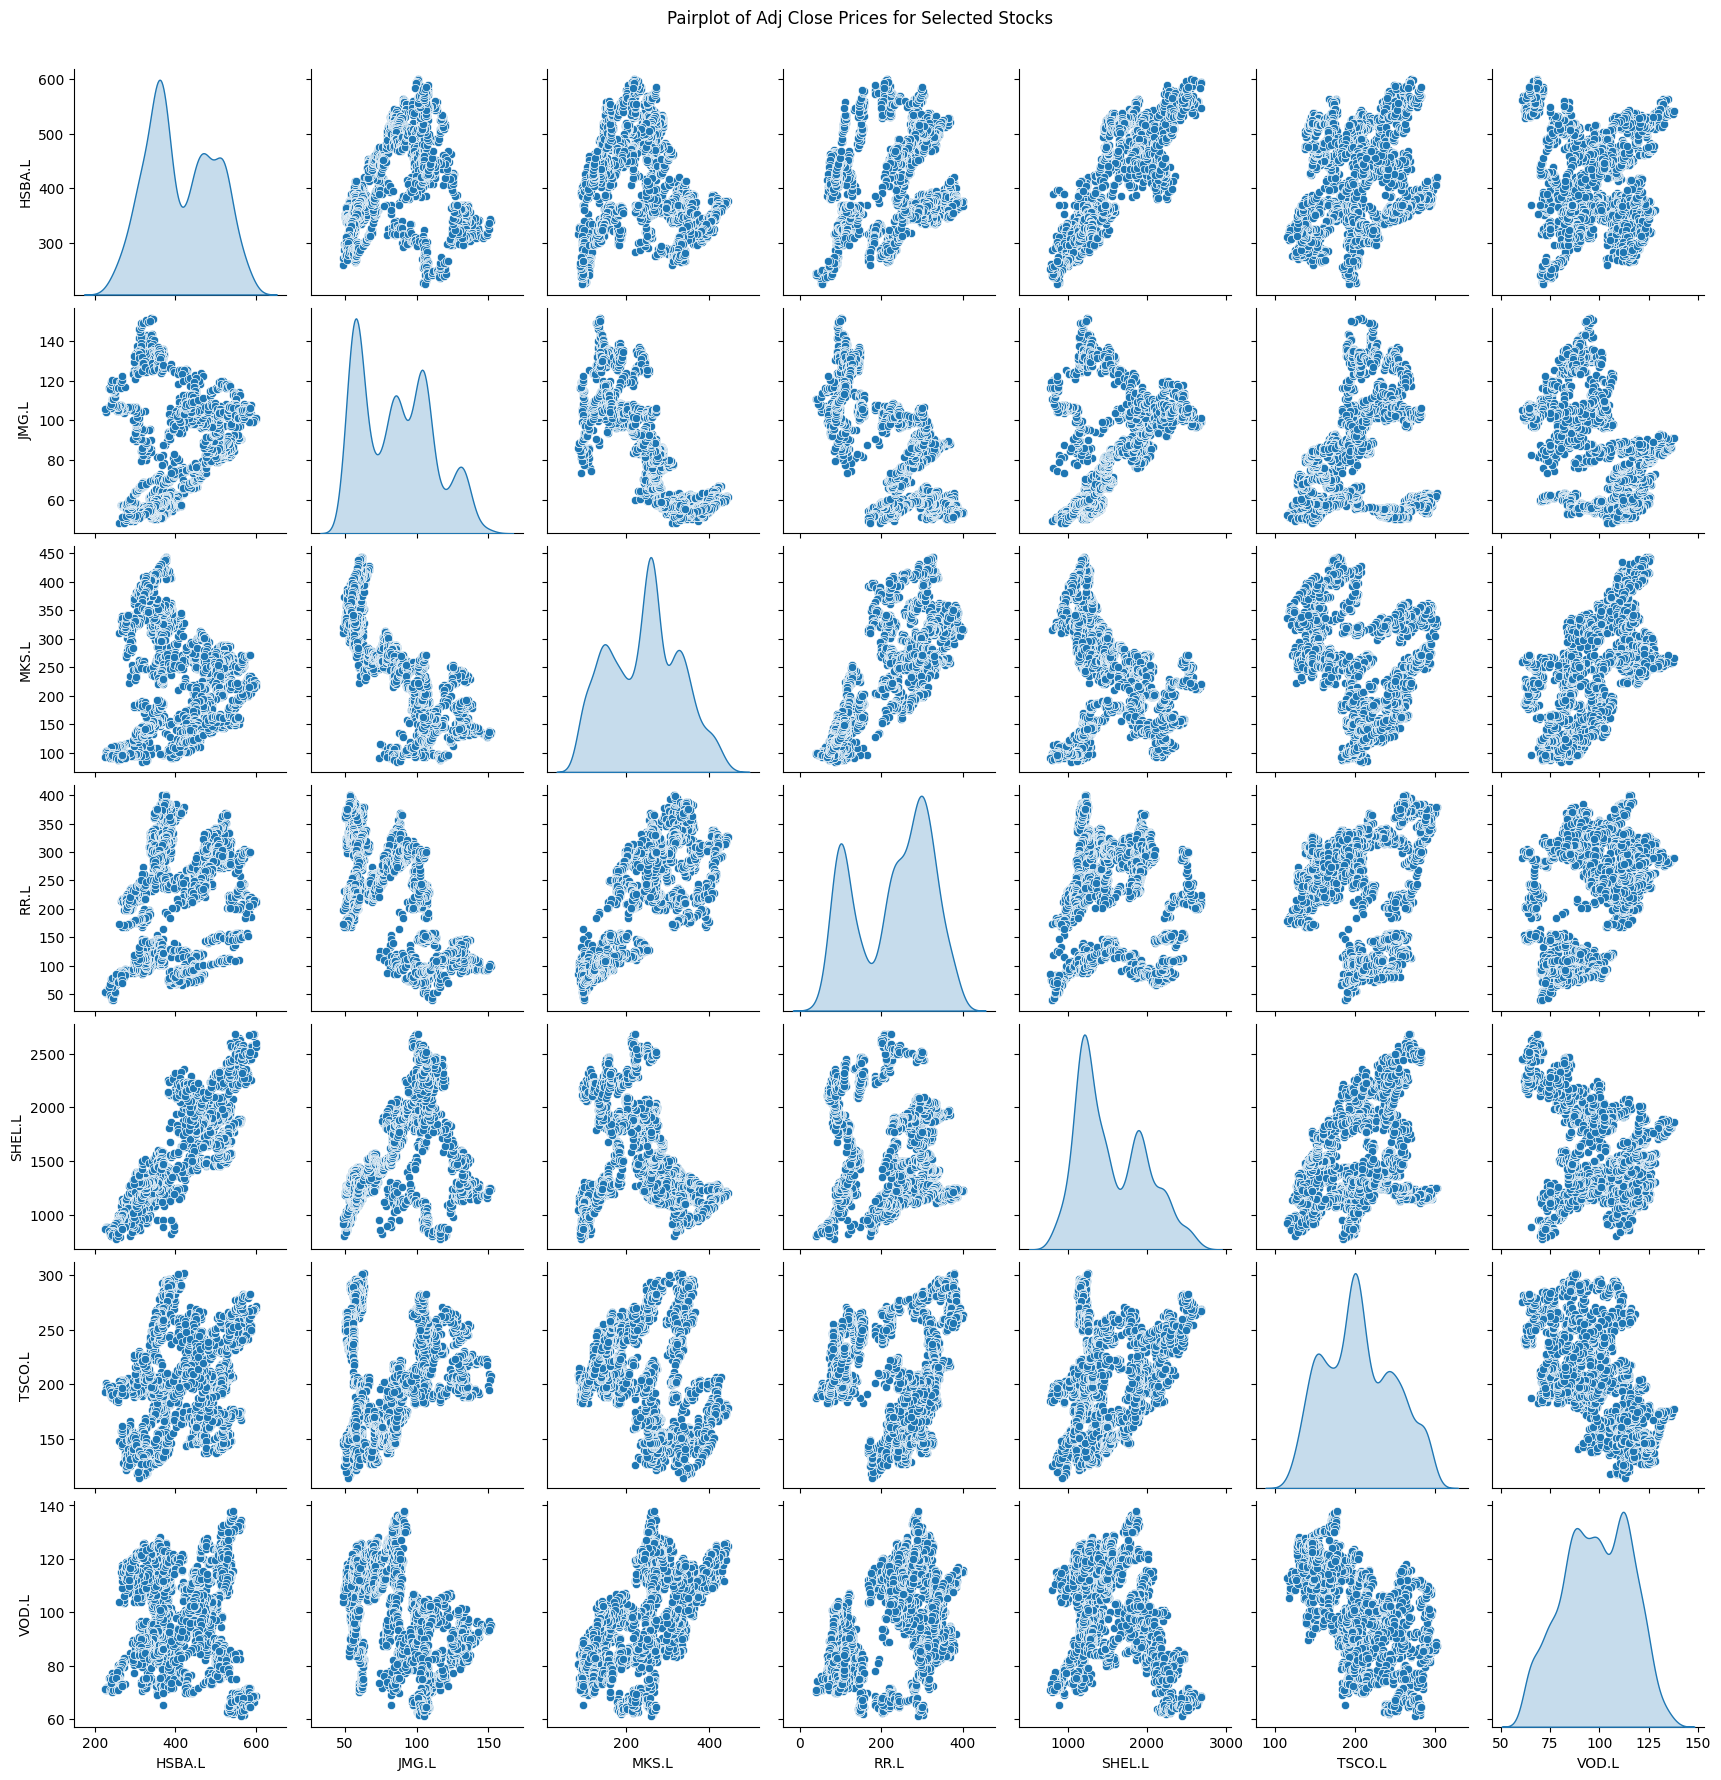

In [20]:
# Pivot the data to have 'Date' as the index and 'Stock' as columns for 'Adj Close'
adj_close_data = stock_data.pivot_table(index='Date', columns='Stock', values='Adj Close')

# Reset index to make 'Date' a column again (for seaborn compatibility)
adj_close_data.reset_index(inplace=True)

# Plotting the pairplot
sns.pairplot(adj_close_data, diag_kind='kde')
plt.suptitle('Pairplot of Adj Close Prices for Selected Stocks', y=1.02)
plt.show()


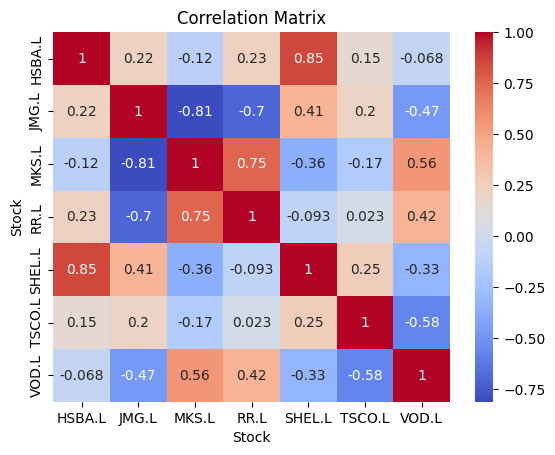

In [21]:
# Correlation Analysis
# Pivot the data to get a DataFrame with stocks as columns
pivot_data = stock_data.pivot_table(index='Date', columns='Stock', values='Adj Close')

# Calculate the correlation matrix
correlation_matrix = pivot_data.corr()

# Plot the correlation matrix using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

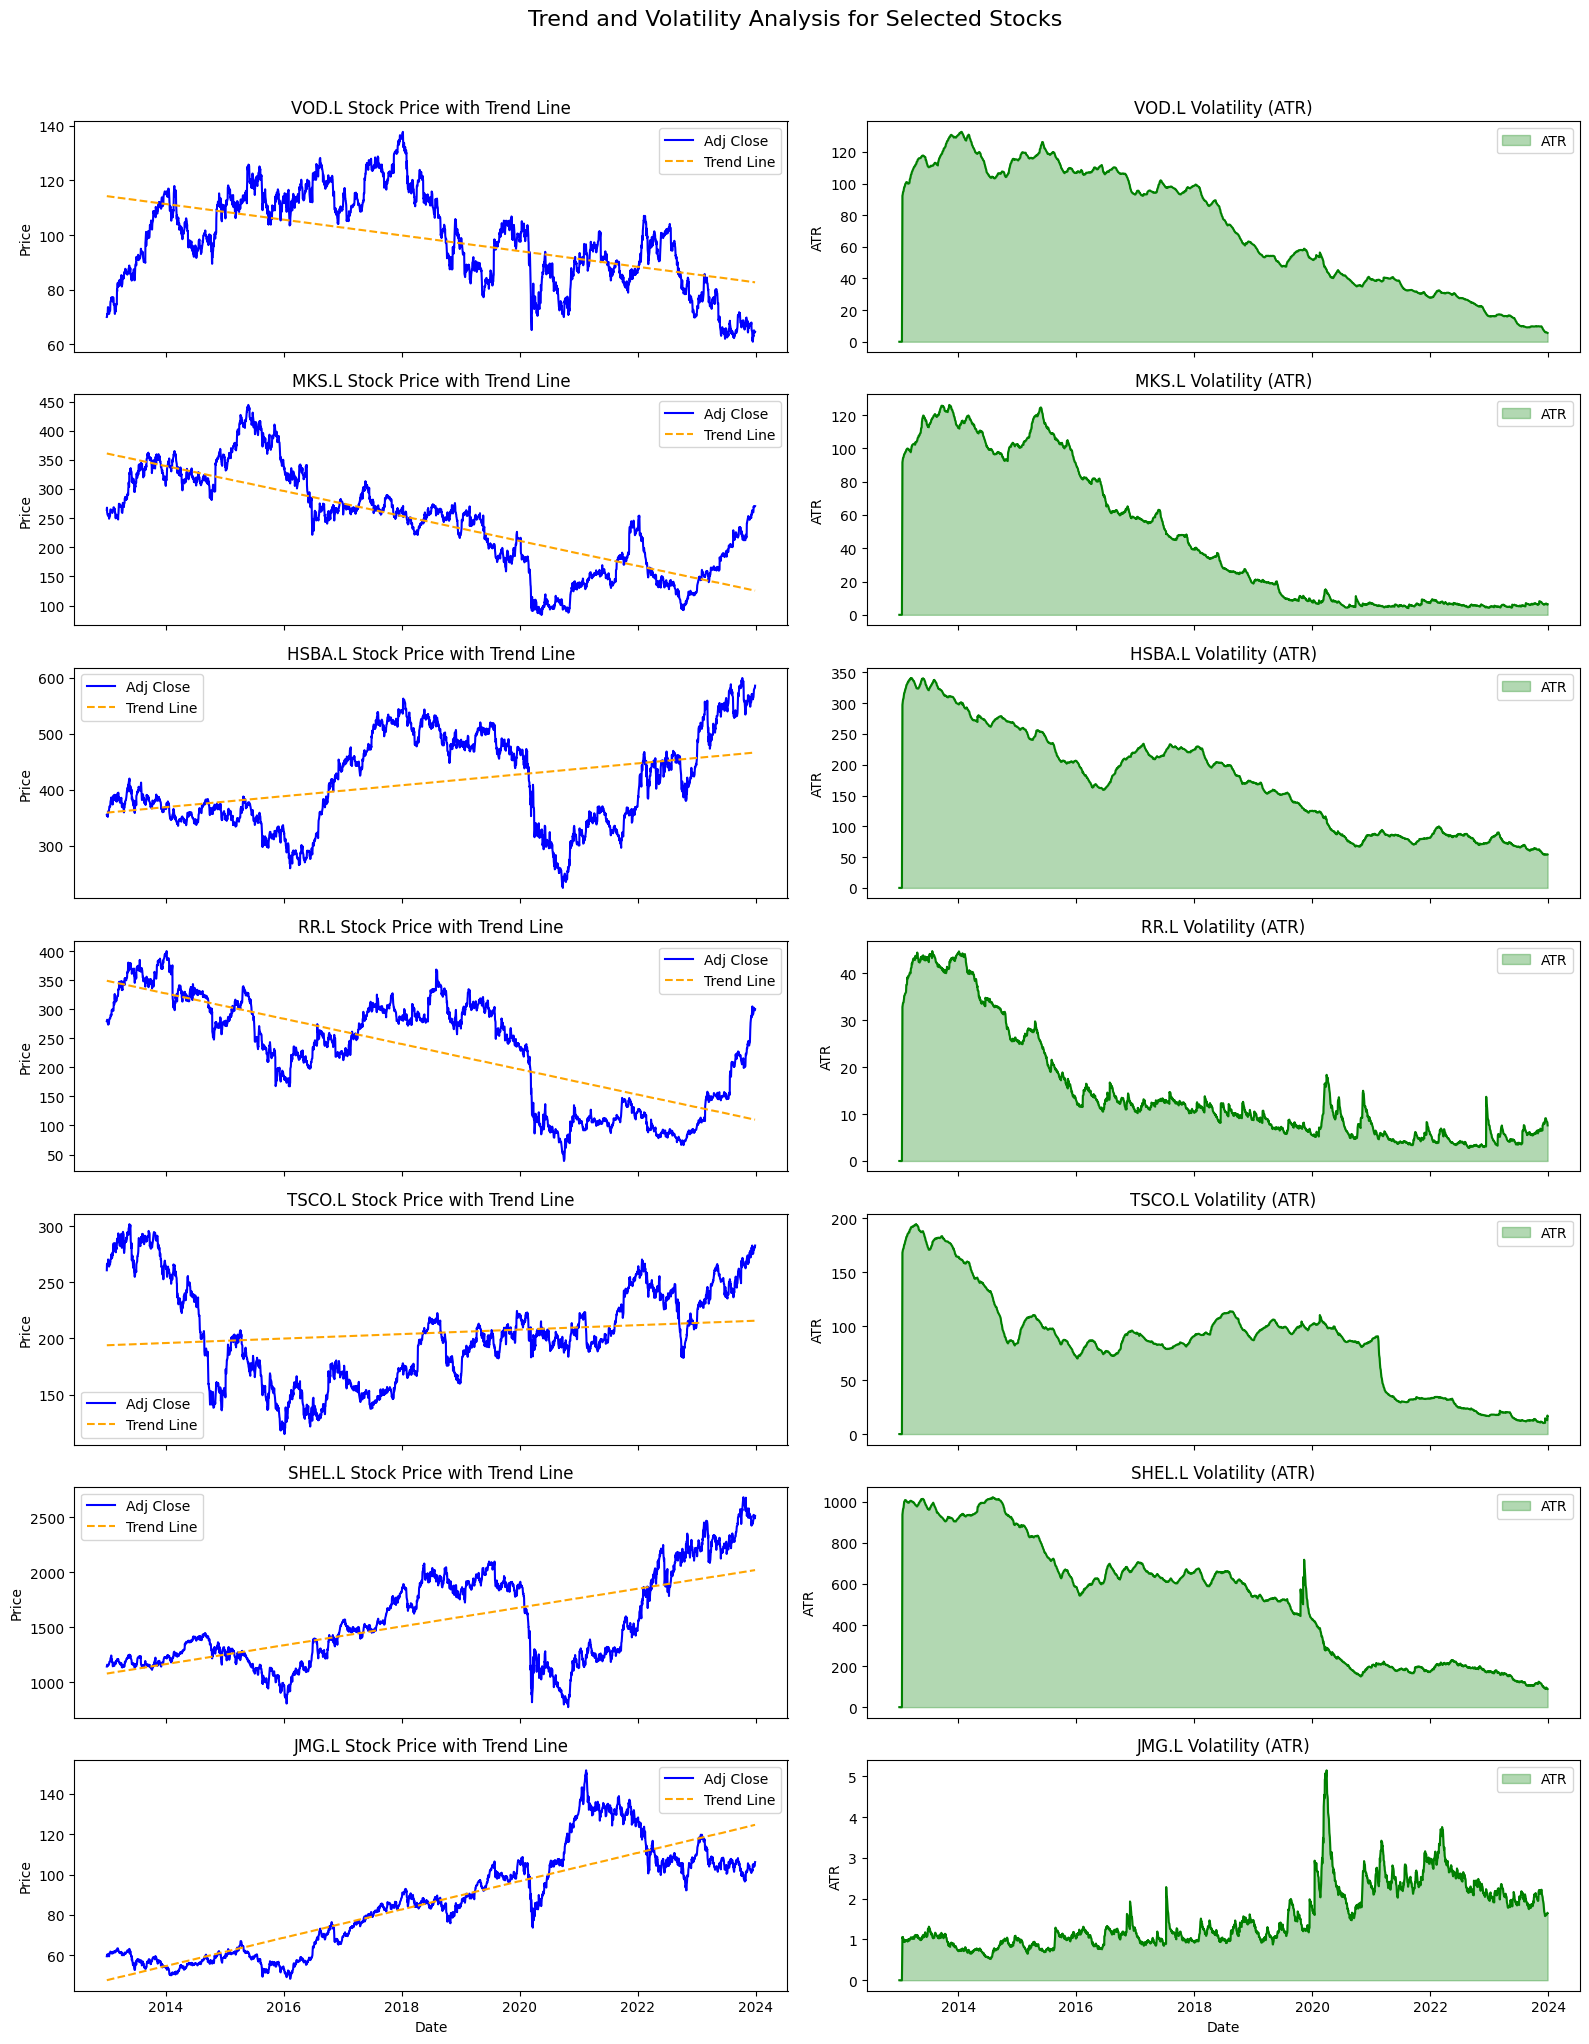

In [22]:
# Initialize subplots with proper figure size and spacing
fig, axs = plt.subplots(len(stocks), 2, figsize=(16, 20), sharex='col')

# Loop through each stock for analysis
for i, stock in enumerate(stocks):
    # Subset data for the current stock
    stock_data_subset = stock_data[stock_data['Stock'] == stock]
    dates = np.array(range(len(stock_data_subset)))

    # Trend analysis using linear regression
    close_prices = stock_data_subset['Adj Close']
    slope, intercept, r_value, p_value, std_err = linregress(dates, close_prices)
    trend_line = slope * dates + intercept

    # Plotting trend line
    axs[i, 0].plot(stock_data_subset.index, close_prices, label='Adj Close', color='blue')
    axs[i, 0].plot(stock_data_subset.index, trend_line, label='Trend Line', linestyle='--', color='orange')
    axs[i, 0].set_title(f'{stock} Stock Price with Trend Line')
    axs[i, 0].set_ylabel('Price')
    axs[i, 0].legend()

    # Volatility analysis using Average True Range (ATR)
    atr_indicator = AverageTrueRange(high=stock_data_subset['High'], low=stock_data_subset['Low'],
                                     close=stock_data_subset['Adj Close'], window=14)
    atr_values = atr_indicator.average_true_range()

    # Plotting ATR
    axs[i, 1].fill_between(stock_data_subset.index, 0, atr_values, label='ATR', color='green', alpha=0.3)
    axs[i, 1].plot(stock_data_subset.index, atr_values, linestyle='-', color='green')
    axs[i, 1].set_title(f'{stock} Volatility (ATR)')
    axs[i, 1].set_ylabel('ATR')
    axs[i, 1].legend()

# Set common X-axis label for the last row of subplots
for ax in axs[-1, :]:
    ax.set_xlabel('Date')

# Adjust layout, add overall title, and display
plt.suptitle('Trend and Volatility Analysis for Selected Stocks', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

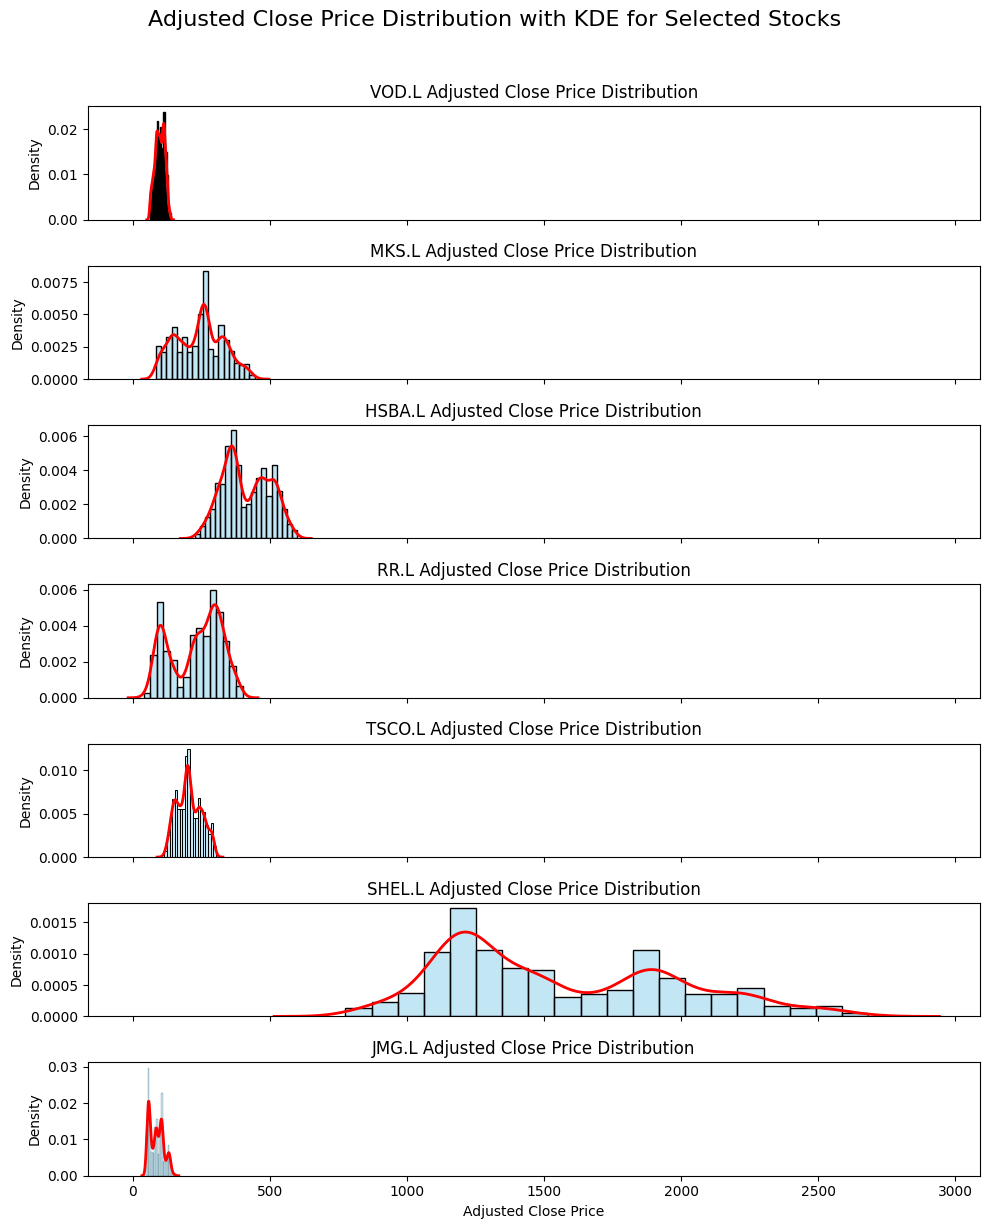

In [23]:
# Initialize subplots with proper figure size and spacing
fig, axs = plt.subplots(len(stocks), figsize=(10, 12), sharex='col')

# Loop through each stock for analysis
for i, stock in enumerate(stocks):
    # Subset data for the current stock
    stock_data_subset = stock_data[stock_data['Stock'] == stock]

    # Plot histogram with KDE
    sns.histplot(stock_data_subset['Adj Close'], kde=True, ax=axs[i], color='skyblue', stat='density')

    # Add distribution line (KDE)
    sns.kdeplot(stock_data_subset['Adj Close'], color='red', ax=axs[i], linewidth=2)

    # Set title and labels
    axs[i].set_title(f'{stock} Adjusted Close Price Distribution')
    axs[i].set_xlabel('Adjusted Close Price')
    axs[i].set_ylabel('Density')

# Set common X-axis label for the last row of subplots
for ax in axs[-1:]:
    ax.set_xlabel('Adjusted Close Price')

# Adjust layout, add overall title, and display
plt.suptitle('Adjusted Close Price Distribution with KDE for Selected Stocks', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [24]:
from scipy.stats import skew, kurtosis
# Initialize lists to store skewness and kurtosis values
skewness_values = []
kurtosis_values = []

# Loop through each stock to calculate skewness and kurtosis
for stock in stocks:
    stock_data_subset = stock_data[stock_data['Stock'] == stock]['Adj Close']
    skewness = skew(stock_data_subset)
    kurt = kurtosis(stock_data_subset)
    skewness_values.append(skewness)
    kurtosis_values.append(kurt)
    print(f'Skewness for {stock}: {skewness}')
    print(f'Kurtosis for {stock}: {kurt}')

    # Create a DataFrame to display the skewness and kurtosis values
skew_kurt_df = pd.DataFrame({
    'Stock': stocks,
    'Skewness': skewness_values,
    'Kurtosis': kurtosis_values
})

print(skew_kurt_df)

Skewness for VOD.L: -0.13198747672635014
Kurtosis for VOD.L: -0.8117749553005376
Skewness for MKS.L: 0.0464822277463541
Kurtosis for MKS.L: -0.8171220388881877
Skewness for HSBA.L: 0.125469489429627
Kurtosis for HSBA.L: -1.042077503345963
Skewness for RR.L: -0.319847627427161
Kurtosis for RR.L: -1.2103225953785874
Skewness for TSCO.L: 0.19097579786825322
Kurtosis for TSCO.L: -0.8141758931387084
Skewness for SHEL.L: 0.5308892600654488
Kurtosis for SHEL.L: -0.7516847628705681
Skewness for JMG.L: 0.32529126828042093
Kurtosis for JMG.L: -0.9480501490246129
    Stock  Skewness  Kurtosis
0   VOD.L -0.131987 -0.811775
1   MKS.L  0.046482 -0.817122
2  HSBA.L  0.125469 -1.042078
3    RR.L -0.319848 -1.210323
4  TSCO.L  0.190976 -0.814176
5  SHEL.L  0.530889 -0.751685
6   JMG.L  0.325291 -0.948050


<ipython-input-25-aaa77ae94de3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Skewness', data=skew_kurt_df, palette='viridis')


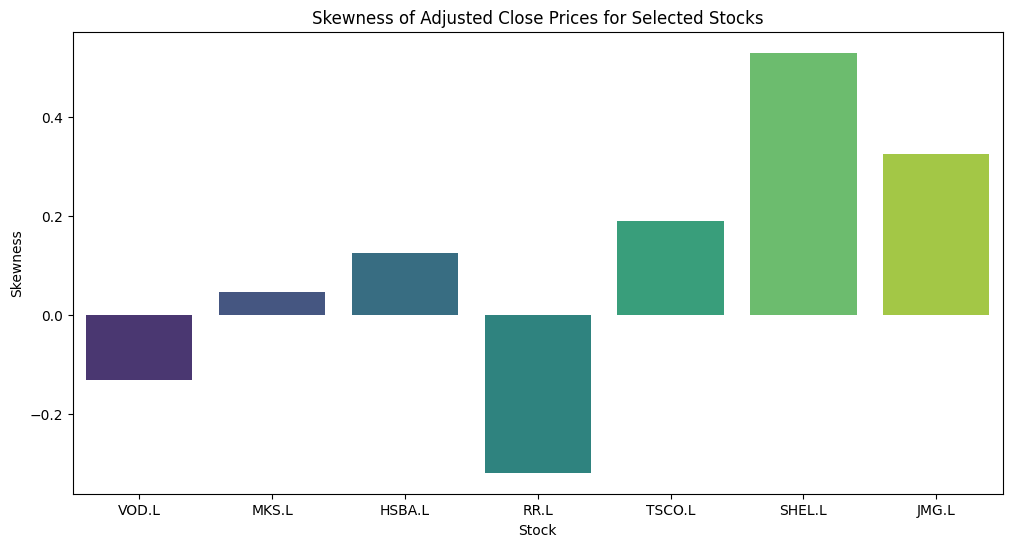

<ipython-input-25-aaa77ae94de3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Kurtosis', data=skew_kurt_df, palette='magma')


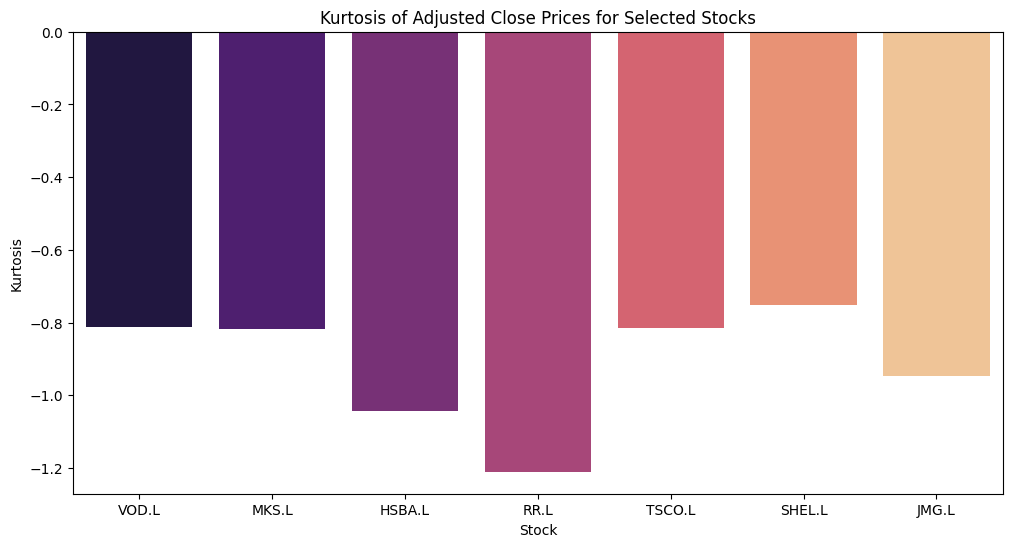

In [25]:
# Bar plot for Skewness
plt.figure(figsize=(12, 6))
sns.barplot(x='Stock', y='Skewness', data=skew_kurt_df, palette='viridis')
plt.title('Skewness of Adjusted Close Prices for Selected Stocks')
plt.xlabel('Stock')
plt.ylabel('Skewness')
plt.show()

# Bar plot for Kurtosis
plt.figure(figsize=(12, 6))
sns.barplot(x='Stock', y='Kurtosis', data=skew_kurt_df, palette='magma')
plt.title('Kurtosis of Adjusted Close Prices for Selected Stocks')
plt.xlabel('Stock')
plt.ylabel('Kurtosis')
plt.show()

# **Traditional** **Methods** **Technical** **Analysis**

# **Moving** **Averages**

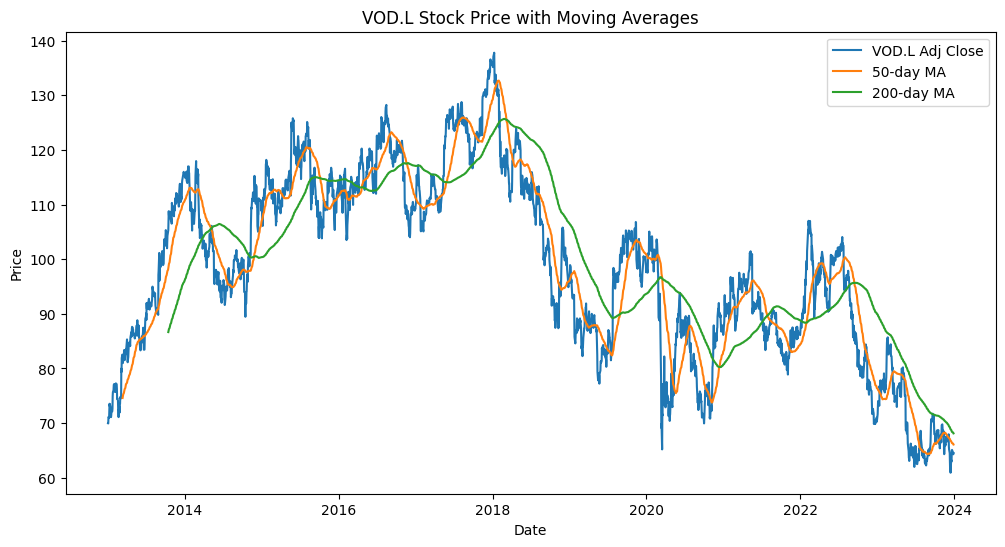

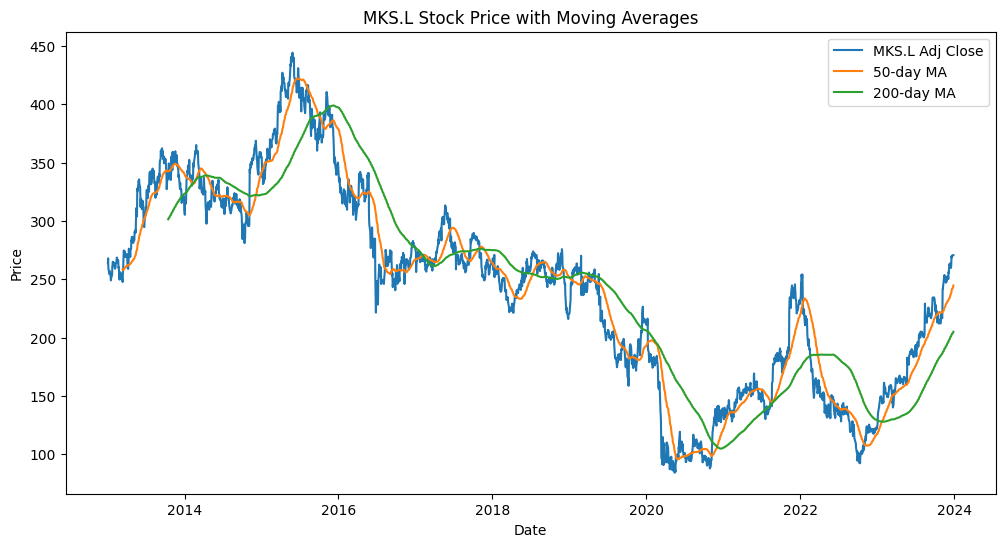

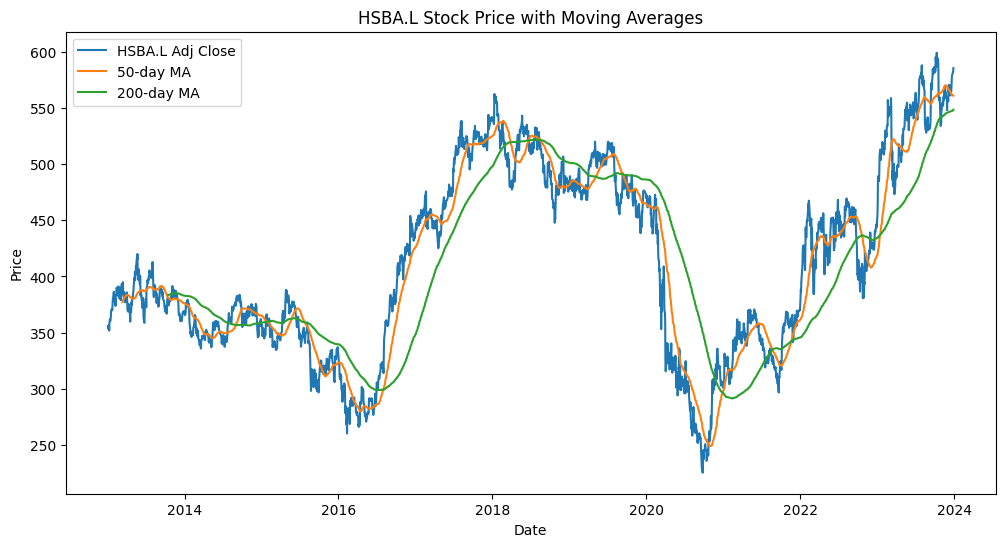

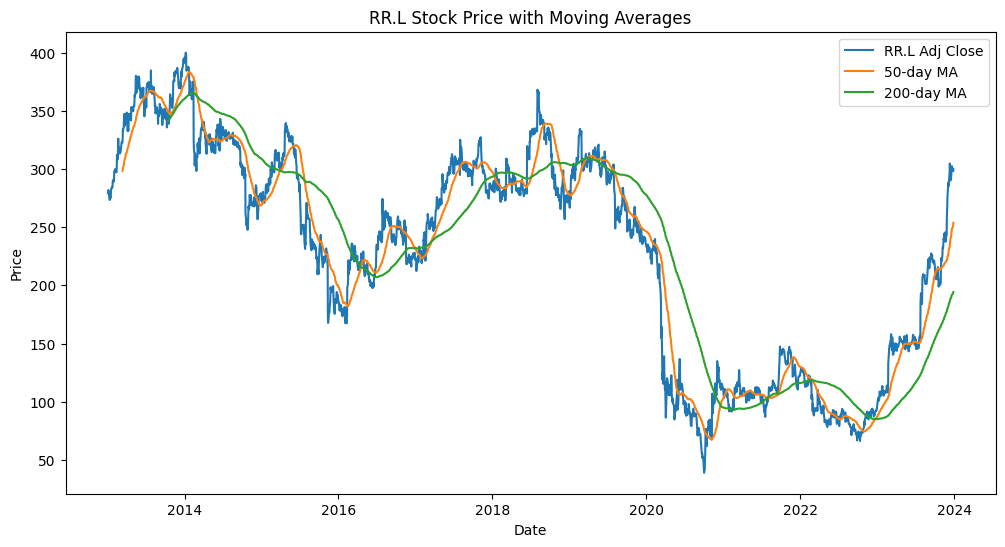

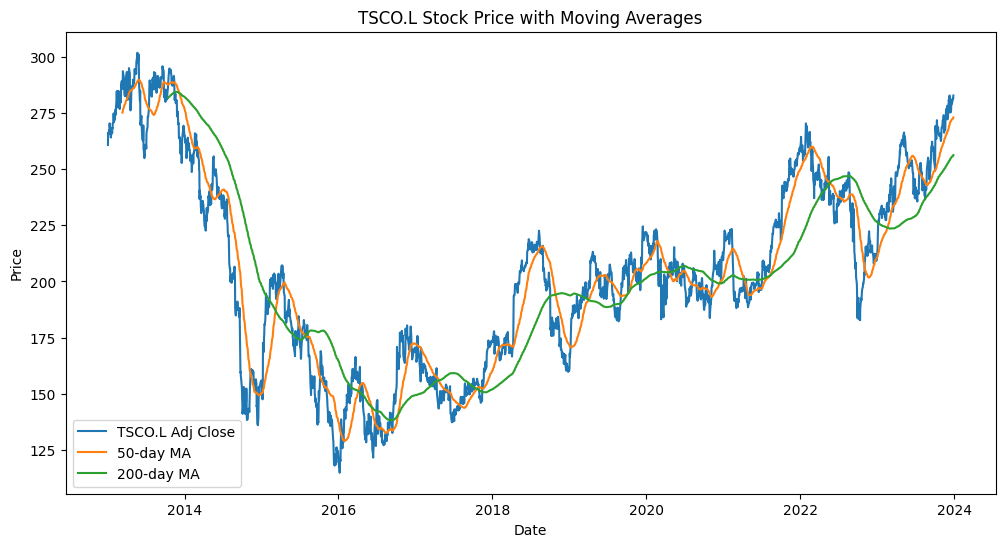

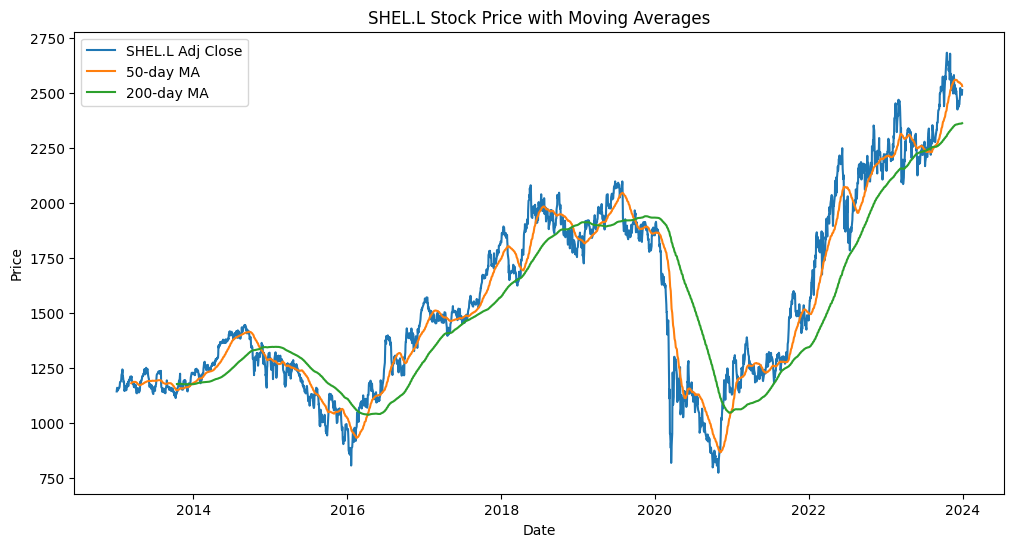

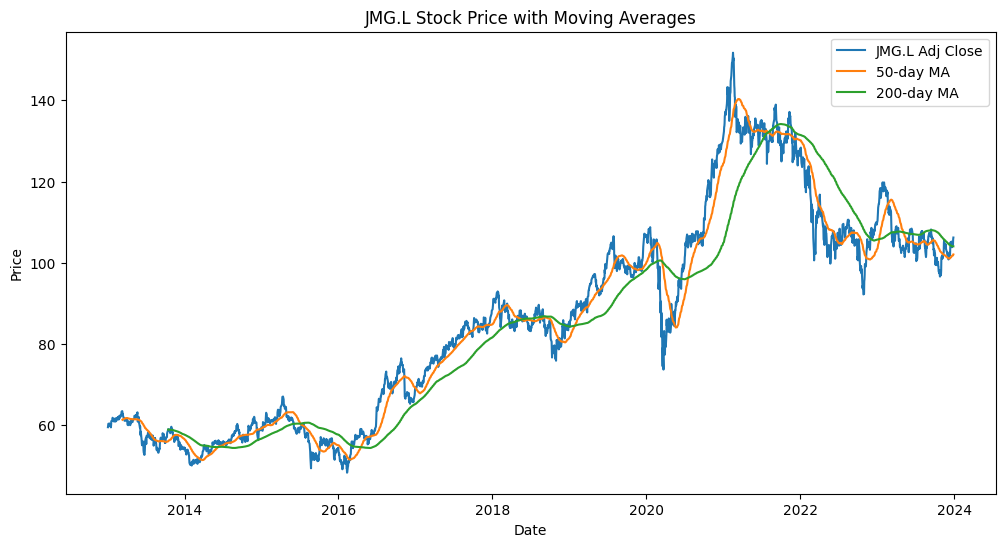

In [26]:
# Moving Averages
short_window = 50
long_window = 200


# Calculate moving averages and plot for each stock
for stock in stocks:
    stock_data_subset = stock_data[stock_data['Stock'] == stock].copy()
    stock_data_subset.loc[:, f'{short_window}-day MA'] = stock_data_subset['Adj Close'].rolling(window=short_window).mean()
    stock_data_subset.loc[:, f'{long_window}-day MA'] = stock_data_subset['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(stock_data_subset.index, stock_data_subset['Adj Close'], label=f'{stock} Adj Close')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{short_window}-day MA'], label=f'{short_window}-day MA')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{long_window}-day MA'], label=f'{long_window}-day MA')
    plt.title(f'{stock} Stock Price with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# **Moving** **Average** **Convergence** **Divergence** **(MACD)**

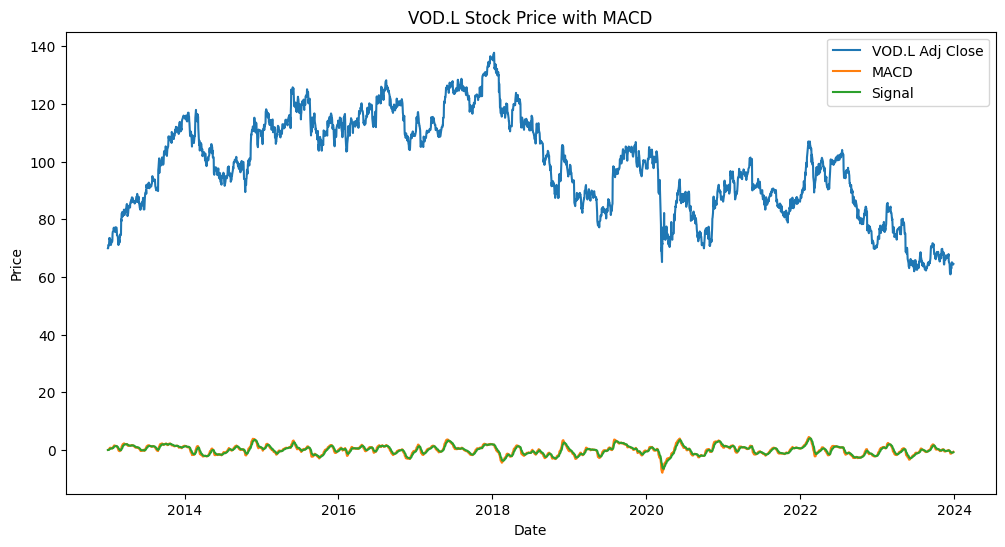

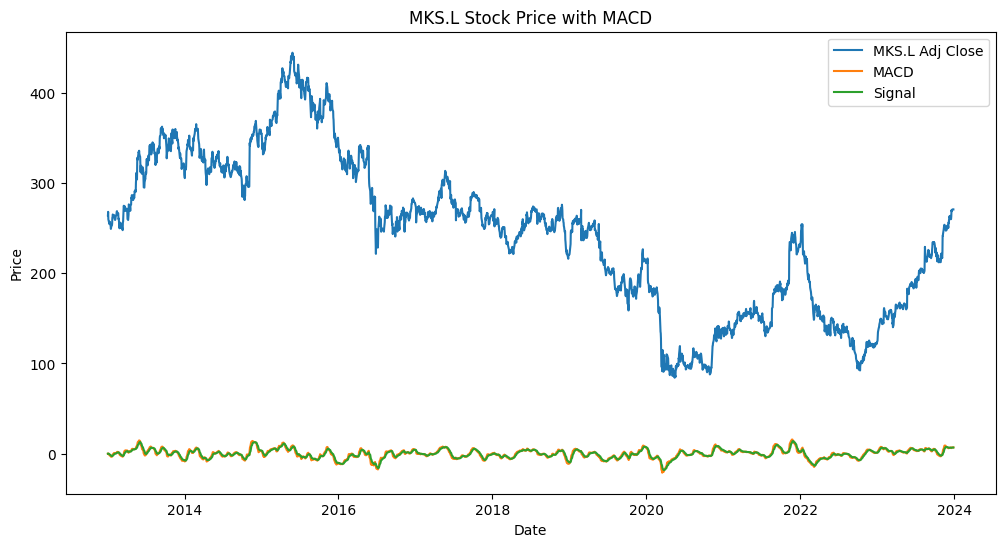

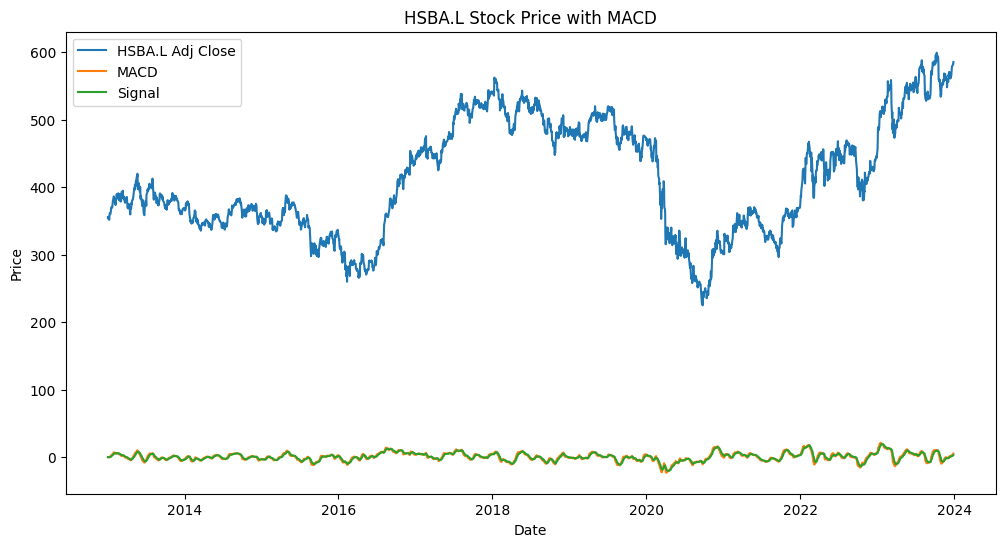

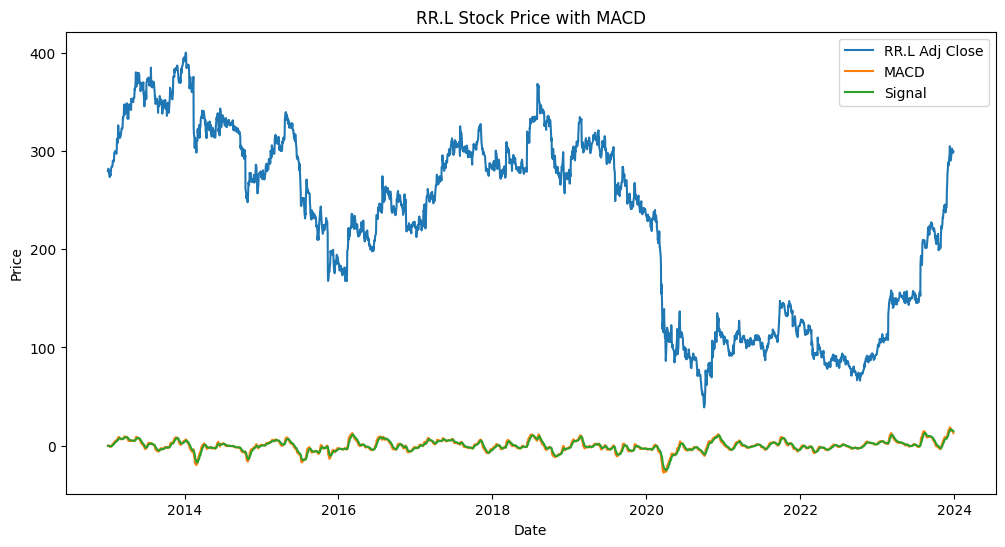

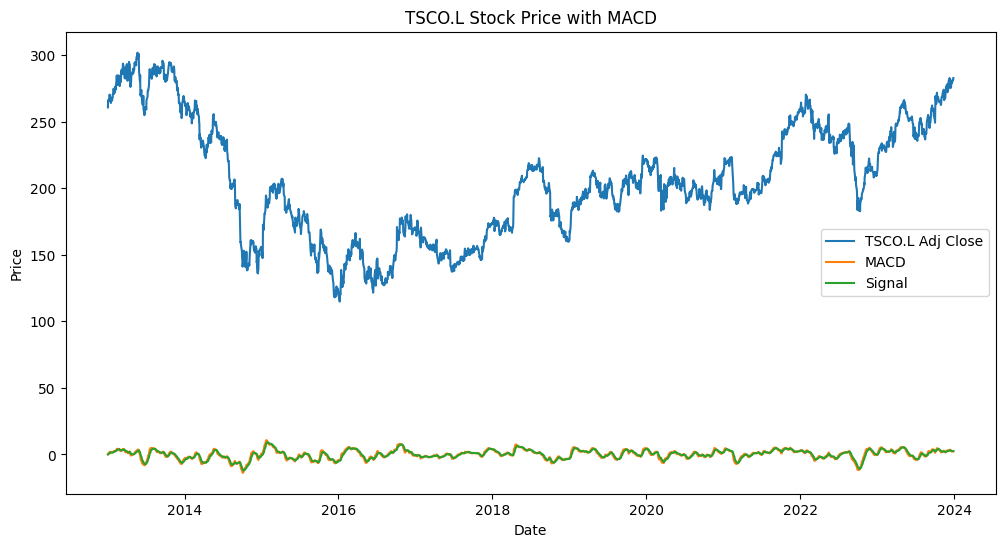

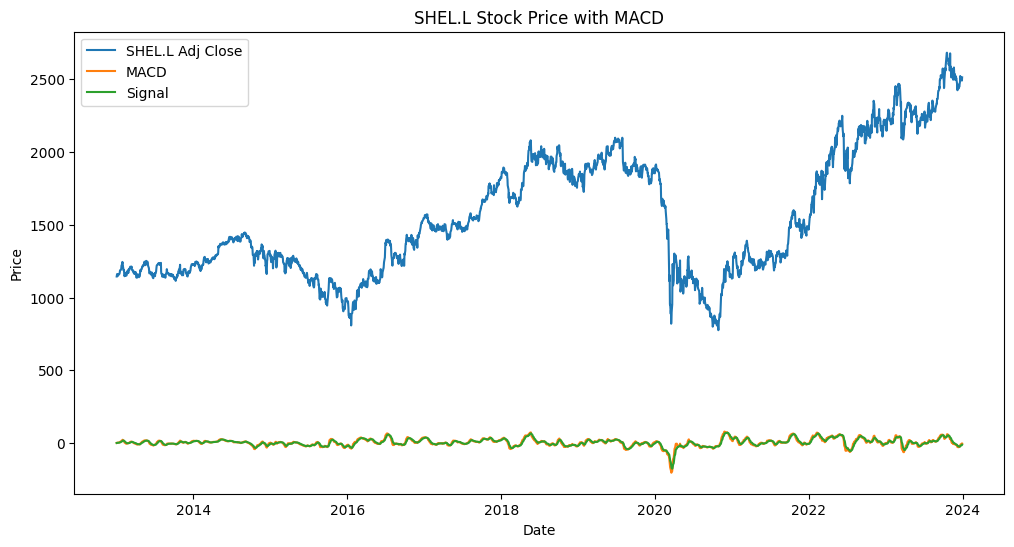

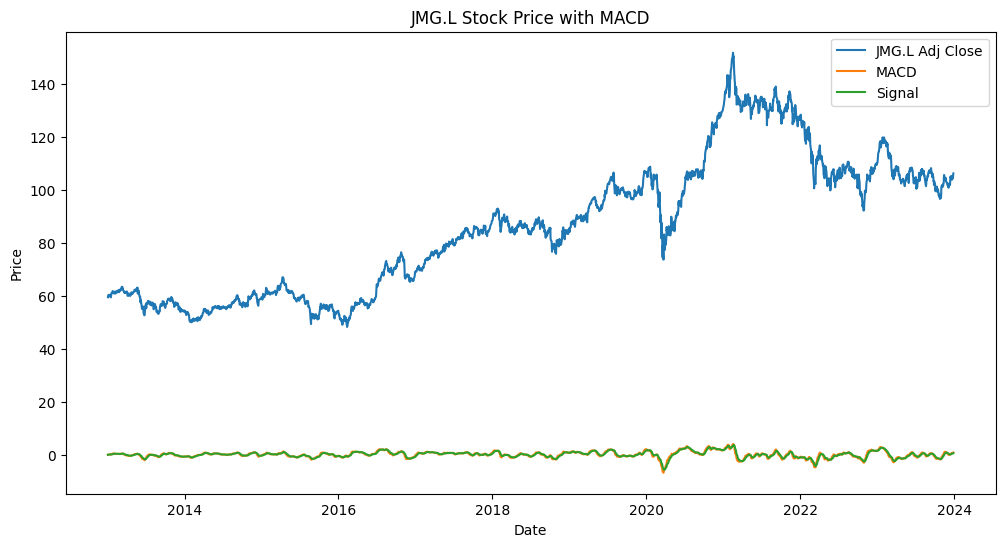

In [27]:
# MACD parameters
fast_period = 12
slow_period = 26
signal_period = 9

# Calculate MACD and plot for each stock
for stock in stocks:
    stock_data_subset = stock_data[stock_data['Stock'] == stock].copy()
    exp1 = stock_data_subset['Adj Close'].ewm(span=fast_period, adjust=False).mean()
    exp2 = stock_data_subset['Adj Close'].ewm(span=slow_period, adjust=False).mean()
    stock_data_subset[f'{stock}_MACD'] = exp1 - exp2
    stock_data_subset[f'{stock}_MACD_Signal'] = stock_data_subset[f'{stock}_MACD'].ewm(span=signal_period, adjust=False).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(stock_data_subset.index, stock_data_subset['Adj Close'], label=f'{stock} Adj Close')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_MACD'], label='MACD')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_MACD_Signal'], label='Signal')
    plt.title(f'{stock} Stock Price with MACD')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# **Bollinger** **Bands**

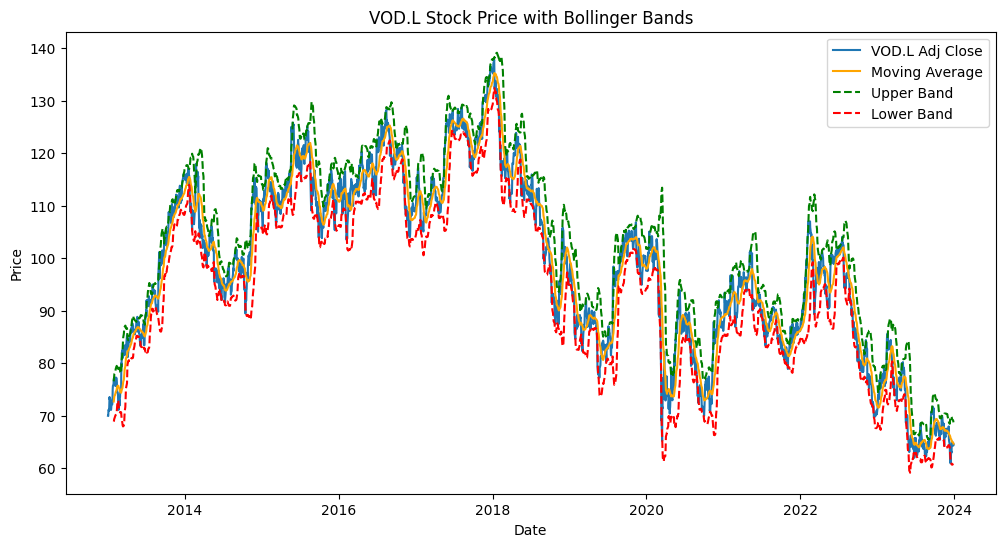

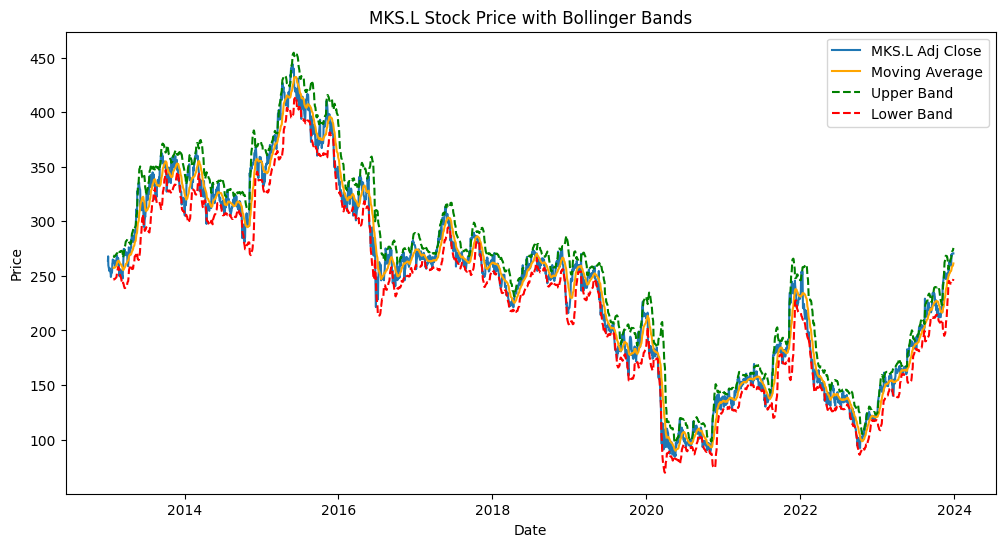

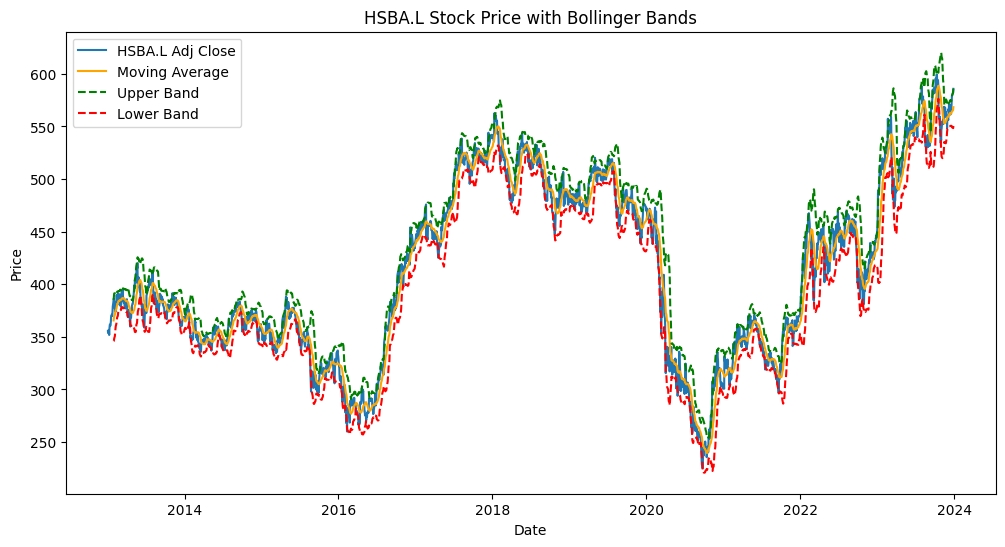

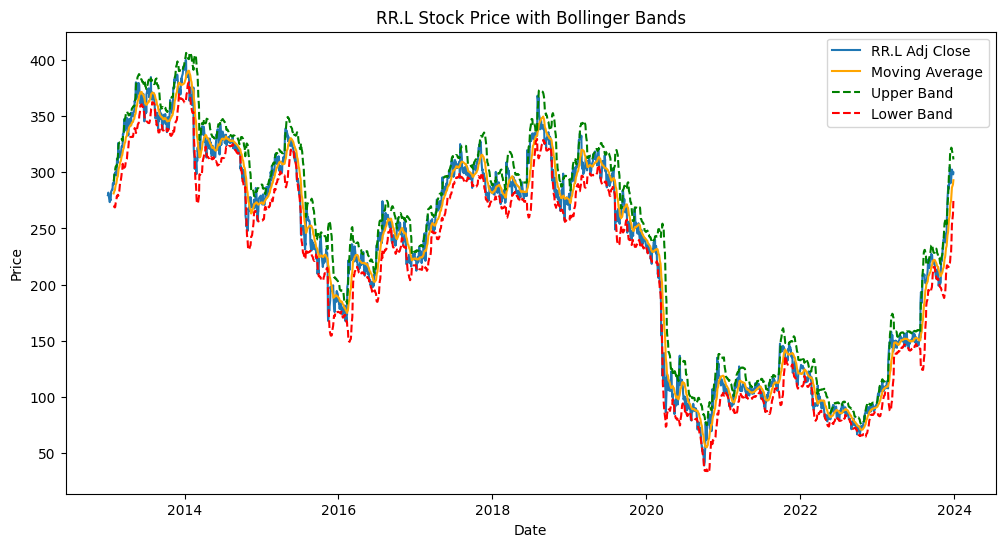

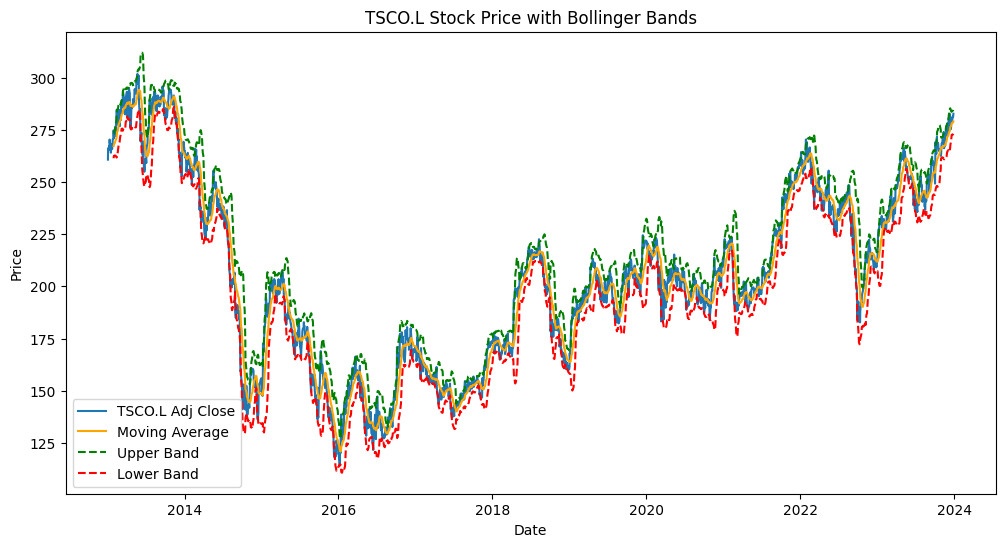

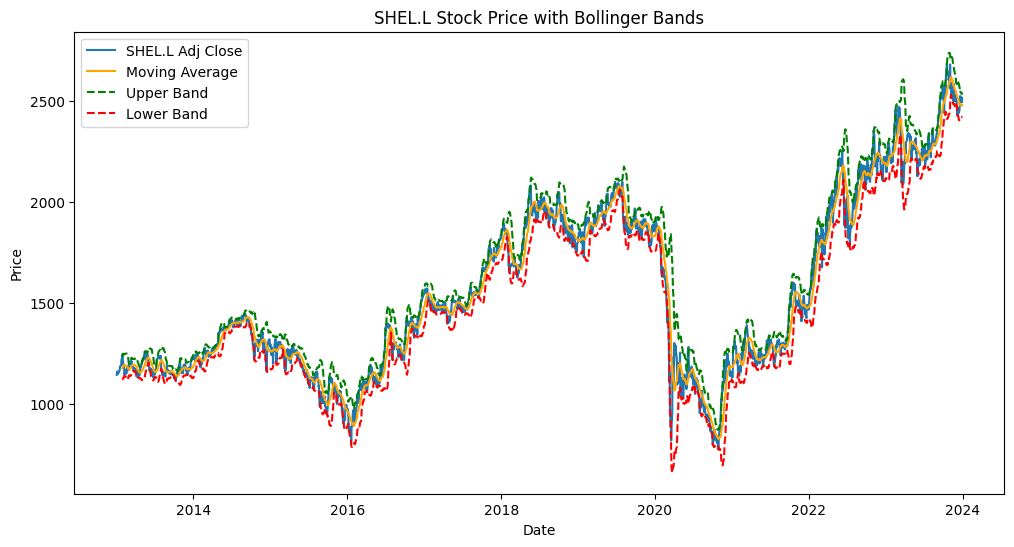

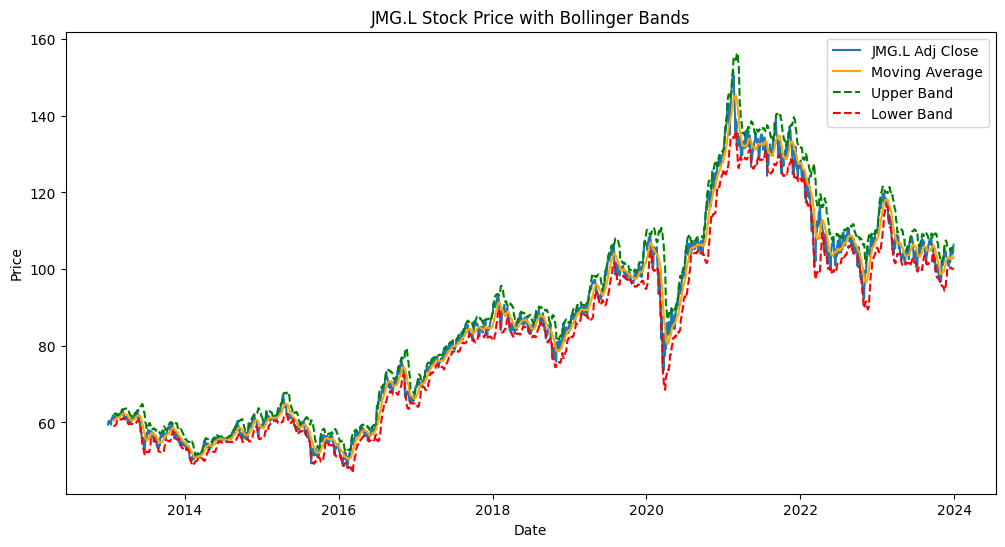

In [28]:
# Bollinger Bands parameters
window = 20
std_dev_factor = 2

# Calculate Bollinger Bands and plot for each stock
for stock in stocks:
    stock_data_subset = stock_data[stock_data['Stock'] == stock].copy()
    rolling_mean = stock_data_subset['Adj Close'].rolling(window=window).mean()
    rolling_std = stock_data_subset['Adj Close'].rolling(window=window).std()
    stock_data_subset[f'{stock}_Upper_Band'] = rolling_mean + std_dev_factor * rolling_std
    stock_data_subset[f'{stock}_Lower_Band'] = rolling_mean - std_dev_factor * rolling_std

    plt.figure(figsize=(12, 6))
    plt.plot(stock_data_subset.index, stock_data_subset['Adj Close'], label=f'{stock} Adj Close')
    plt.plot(stock_data_subset.index, rolling_mean, label='Moving Average', color='orange')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_Upper_Band'], label='Upper Band', linestyle='--', color='green')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_Lower_Band'], label='Lower Band', linestyle='--', color='red')
    plt.title(f'{stock} Stock Price with Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# **Hybrid** **Model**
# **Architecture** **of** **Moving** **Average** **+** **LSTM**

In [40]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Now, recalculate the moving averages
stock_data['MA50'] = stock_data['Adj Close'].rolling(window=50).mean()
stock_data['MA200'] = stock_data['Adj Close'].rolling(window=200).mean()

# Features and Target
features = stock_data[['MA50', 'MA200']].values
target = stock_data['Adj Close'].pct_change().shift(-1).fillna(0).values  # Fill NaN with 0

# Calculation of the size of the training set (80% of the total data)
train_size = int(len(features) * 0.8)

# Splitting the features and target arrays into training and testing sets
X_train, y_train = features[:train_size], target[:train_size]
X_test, y_test = features[train_size:], target[train_size:]

# Reshape features to 2D for scaling
X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_test_2D = X_test.reshape(X_test.shape[0], -1)

# Initialize and fit the scaler on the training data, then transform both training and test data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2D)
X_test_scaled = scaler.transform(X_test_2D)

# Reshape back to 3D after scaling for LSTM input
X_train = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

# Simplified model for troubleshooting
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=RandomNormal(mean=0.0, stddev=0.05)))
model.add(Dense(1))

# Adjusted learning rate and optimizer
optimizer = Adam(lr=0.0001)

# Compiling the model with a different loss function for troubleshooting
model.compile(optimizer=optimizer, loss='mae')  # Using Mean Absolute Error

# Fitting the simplified LSTM model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions using the trained LSTM model
y_pred_lstm = model.predict(X_test)

Epoch 1/10
438/438 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 2/10
438/438 [==============================] - 2s 5ms/step - loss: nan - val_loss: nan
Epoch 3/10
438/438 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 4/10
438/438 [==============================] - 3s 6ms/step - loss: nan - val_loss: nan
Epoch 5/10
438/438 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 6/10
438/438 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 7/10
438/438 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 8/10
438/438 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 9/10
438/438 [==============================] - 2s 4ms/step - loss: nan - val_loss: nan
Epoch 10/10
122/122 [==============================] - 1s 2ms/step
